# PENO Model

In [1]:
import networkx
import random
import numpy
from mesa import Agent, Model
from scipy.stats import bernoulli
from mesa.time import RandomActivation
from mesa.space import ContinuousSpace
import matplotlib.pyplot as plt
import matplotlib.cm as cm

At my cognitive science study program, we have master seminar, where we have to present our idea for the master thesis. When presenting it, we also need to choose one article, which serves as the basis for our work.

Well, I usually end up combining different things together, so it is hard to choose just one article that serves as the basis of my work. But I did find one article, which combined the individual differences in the network analysis of the opinion changing and spreading. Which is also what I am doing.

The article was [Modeling Personalized Dynamics of Social Network and Opinion at Individual Level](https://arxiv.org/abs/1811.02791).

I don't think I modeled it exactly as they describe it in the article. I could not even reproduce some of the results, that they made. But this was my attempt. 

In [2]:
number_of_agents = 50
size = 8
neighbor_difference = 1
Blues = plt.get_cmap()

In [3]:
class SpaceModel(Model):
    def __init__(self, N, size):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.grid = ContinuousSpace(size, size, False)
    
        #there the agents are created and places in the sceduler and in the grid
        for i in range(N):
            a = Person(i, self, size)
            self.schedule.add(a)
            self.grid.place_agent(a, (random.randrange(1,size-1), random.randrange(1,size-1)))
            
    def step(self):
        self.schedule.step()

In [4]:
class Person(Agent):
    
    def __init__(self, unique_id, model, size):
        super().__init__(unique_id, model)
        self.size = size
        self.opinion = [random.gauss(random.randint(-size+1, size-1),1), random.gauss(random.randint(-size+1, size-1),1)]
        self.trend = random.randint(0,359)
        leadership_chance = round(random.uniform(0.0, 1.0), 2)
        if leadership_chance < 0.1:
            self.leadership = 1
        else: 
            self.leadership = 0.001
        self.openess = get_personality_trait(0.3, 1)
        self.agreeablness = get_personality_trait(0., 1)
        self.neuroticism = get_personality_trait(1, 1)
        self.all_positions = [tuple([self.opinion[0], self.opinion[1], True])]
        self.color = "black"
    
    def step(self):
        neighbors = [a for a in model.schedule.agents if numpy.sqrt(abs(self.opinion[0]-a.opinion[0])+abs(self.opinion[1]-self.opinion[1])) < neighbor_difference and self.openess * a.openess > 0.3]
        neighbors = self.model.grid.get_neighbors(self.pos, radius=1, include_center=False)
        all_leadership = numpy.mean([p.leadership for p in neighbors])
        difference_in_direction = numpy.mean([numpy.cos([numpy.radians(self.trend - p.trend) for p in neighbors])])*self.agreeablness
        if numpy.isnan(difference_in_direction) or difference_in_direction == 0 or numpy.isinf(difference_in_direction):
            difference_in_direction = 0.01
        impact = (1/(self.leadership/all_leadership))*difference_in_direction*30
        self.trend = random.gauss(self.trend + numpy.rad2deg(difference_in_direction), 1/max(0.001, self.neuroticism))
        self.opinion[0] = self.opinion[0] + numpy.cos(numpy.radians(self.trend))*impact
        self.opinion[1] = self.opinion[1] + numpy.sin(numpy.radians(self.trend))*impact
        continious = True
        if self.opinion[0] > self.size:
            self.opinion[0] = -self.size
            continious = False
        if self.opinion[0] < -self.size:
            self.opinion[0] = self.size
            continious = False
        if self.opinion[1] > self.size:
            self.opinion[1] = -self.size
            continious = False
        if self.opinion[1] < -self.size:
            self.opinion[1] = self.size
            continious = False
        self.all_positions.append(tuple([self.opinion[0], self.opinion[1], continious]))

In [5]:
def get_personality_trait(mean, sd):
    personality = random.gauss(mean, sd)
    if personality > 1:
        personality = 1
    if personality < 0:
        personality = 0
    return personality

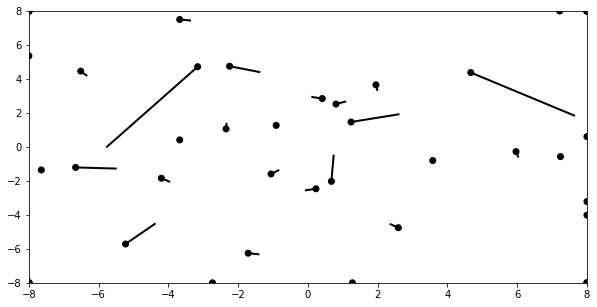

In [6]:
model = SpaceModel(number_of_agents, size)
for i in range(1):
    model.step()
    agents = [a for a in model.schedule.agents]
    xs = [float(x.opinion[0]) for x in agents]
    ys = [float(x.opinion[1]) for x in agents]
    col = [x.color for x in agents]
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(xs, ys, c=col)
    for a in model.schedule.agents:
        position1 = a.all_positions[-1]
        position2 = a.all_positions[-2]
        if not position1[2] or not position2[2]:
            continue
        ax.plot((position1[0], position2[0]), (position1[1], position2[1]), color=a.color, linestyle='-', linewidth=2)
        if len(a.all_positions) > 2:
            position3 = a.all_positions[-3]
            if not position3[2]:
                continue
            ax.plot((position2[0], position3[0]), (position2[1], position3[1]), color=a.color, linestyle='-', linewidth=2)
        if len(a.all_positions) > 3:
            position4 = a.all_positions[-4]
            if not position4[2]:
                continue
            ax.plot((position4[0], position3[0]), (position4[1], position3[1]), color=a.color, linestyle='-', linewidth=2)
    ax.set_xlim([-8, 8])
    ax.set_ylim([-8, 8])
    plt.savefig("model-" + str(i) + ".png")